In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


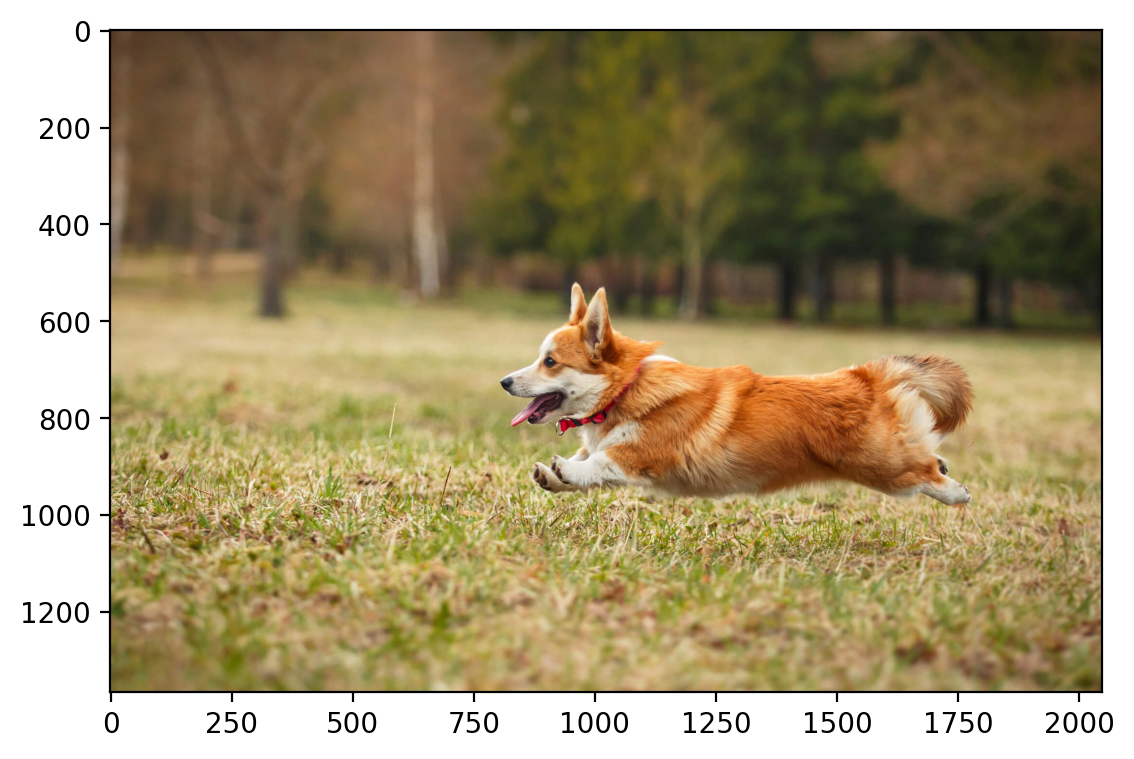

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)


In [ ]:
img_scaled = img_scaled.to(device)

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 150, 150)
crop.shape

torch.Size([3, 150, 150])

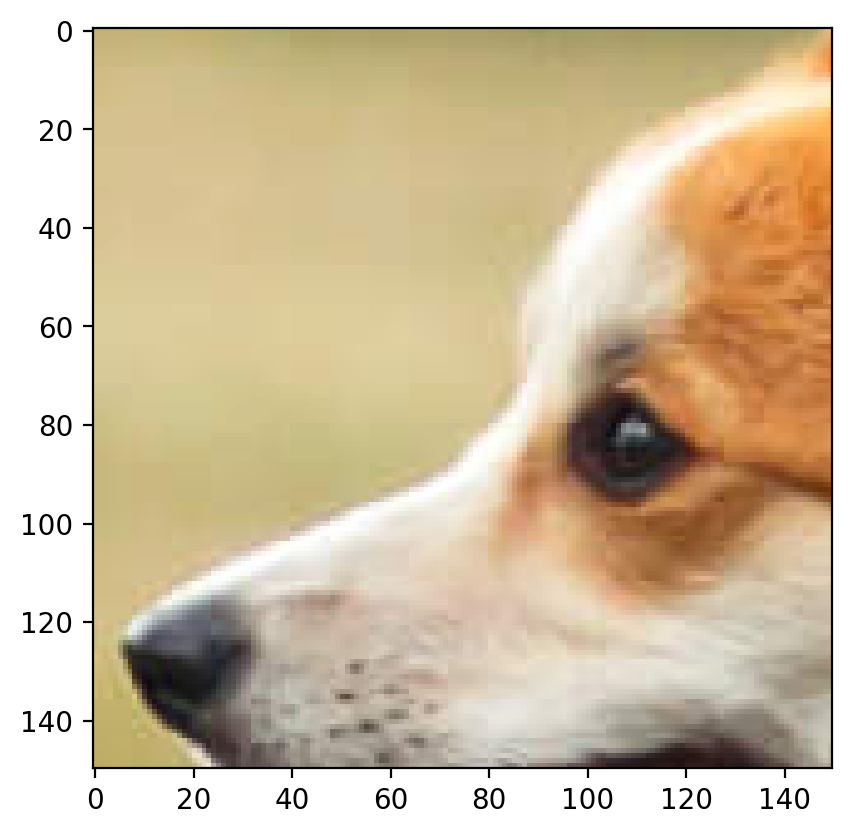

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [ ]:
crop = crop.to(device)


In [ ]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
dog_X,dog_y = create_coordinate_map(crop)

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [ ]:
dog_X_scaled.shape

torch.Size([22500, 2])

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title="",h=None,w=None):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    if(h==None ):
      num_channels, height, width = original_img.shape
    else:
      num_channels, height, width = 3,300,300
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2),random_state=2)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


train on 150 X 150

In [ ]:
X_rff = create_rff_features(dog_X_scaled, 15000, 0.008)

In [ ]:
X_rff.shape

torch.Size([22500, 15000])

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_y, 2500)

Epoch 0 loss: 0.491349
Epoch 100 loss: 0.083492
Epoch 200 loss: 0.018509
Epoch 300 loss: 0.010409
Epoch 400 loss: 0.008002
Epoch 500 loss: 0.006501
Epoch 600 loss: 0.005388
Epoch 700 loss: 0.004513
Epoch 800 loss: 0.003806
Epoch 900 loss: 0.003222
Epoch 1000 loss: 0.002735
Epoch 1100 loss: 0.002325
Epoch 1200 loss: 0.001979
Epoch 1300 loss: 0.001686
Epoch 1400 loss: 0.001438
Epoch 1500 loss: 0.001228
Epoch 1600 loss: 0.001049
Epoch 1700 loss: 0.000898
Epoch 1800 loss: 0.000770
Epoch 1900 loss: 0.000662
Epoch 2000 loss: 0.000570
Epoch 2100 loss: 0.000492
Epoch 2200 loss: 0.000426
Epoch 2300 loss: 0.000369
Epoch 2400 loss: 0.000322


0.0002811909362208098

In [ ]:
crop.shape

torch.Size([3, 150, 150])

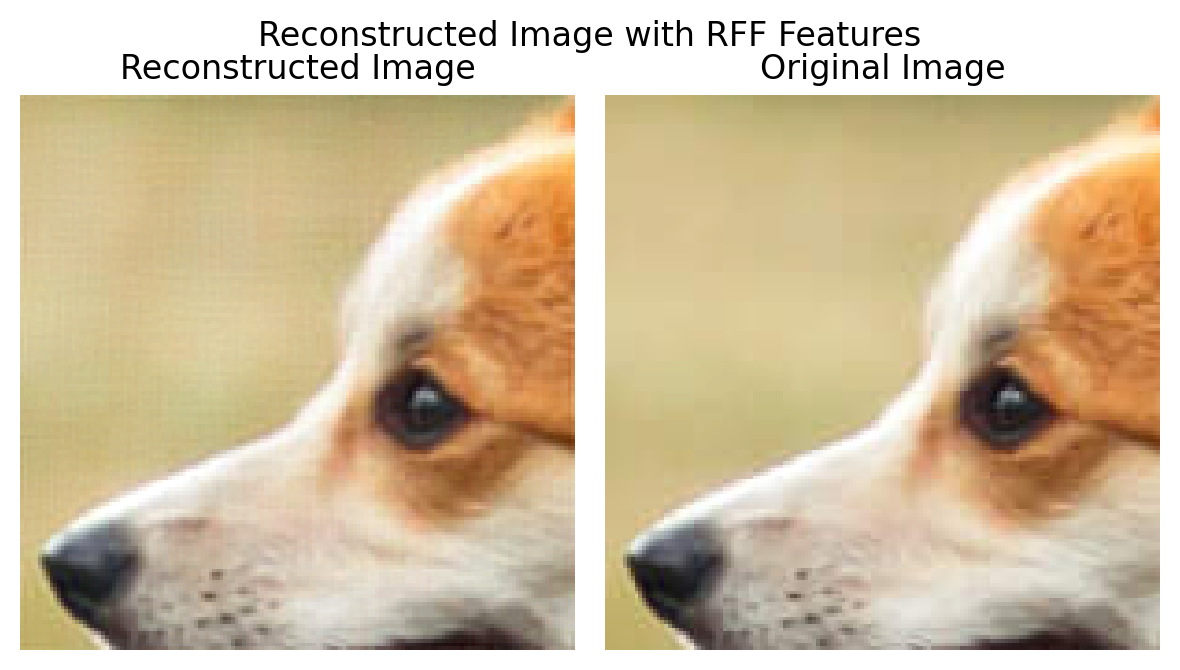

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

Superresolution: perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image.

create a coordinate map of 300 X 300

In [ ]:
dog2_X,dog2_y = create_coordinate_map(crop, scale=2)

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog2_X.cpu())

# Scale the X coordinates
dog2_X_scaled = scaler_X.transform(dog2_X.cpu())

# Move the scaled X coordinates to the GPU
dog2_X_scaled = torch.tensor(dog2_X_scaled).to(device)

# Set to dtype float32
dog2_X_scaled = dog2_X_scaled.float()

In [ ]:
X2_rff = create_rff_features(dog2_X_scaled, 15000, 0.008)

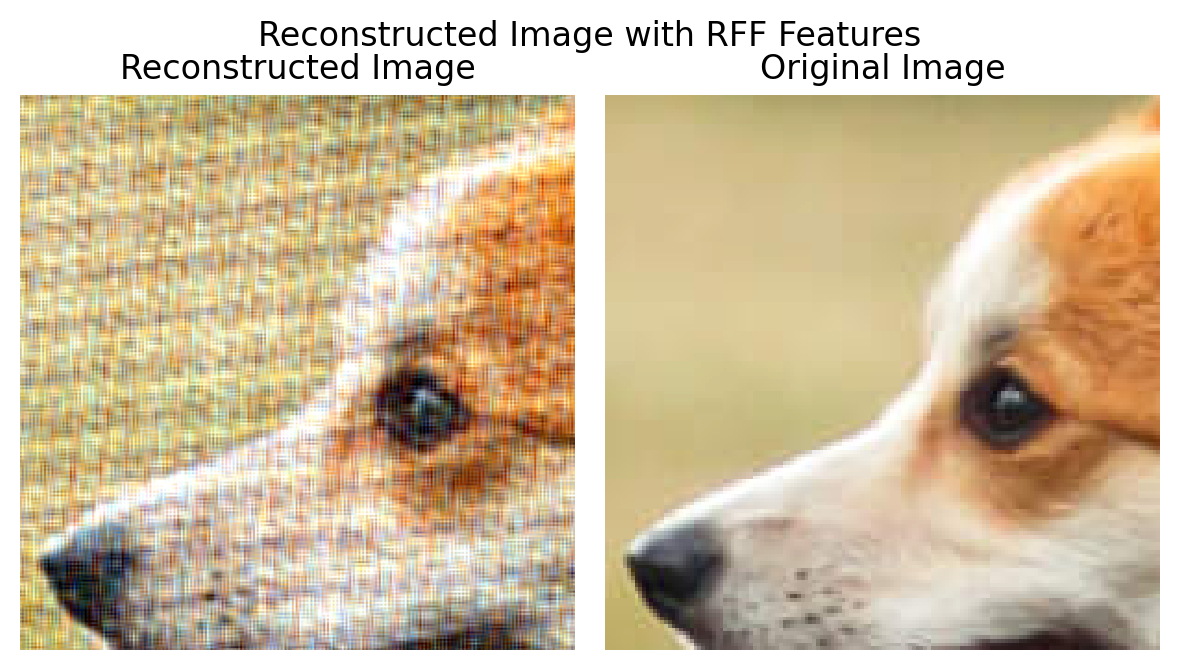

In [ ]:
plot_reconstructed_and_original_image(crop, net, X2_rff, title="Reconstructed Image with RFF Features",h='300',w='300')